In [1]:
import os
import pywt
import glob
import random
import datetime
import numpy as np
import pandas as pd
from scipy.stats import entropy
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

2024-07-04 08:17:41.489180: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 08:17:44.797237: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Load data and preprocess

In [2]:
xTrain = np.load("./xTrain.npy")
yTrain = np.load("./yTrain.npy", allow_pickle=True)

xTest = np.load("./xTest.npy")
yTest = np.load("./yTest.npy", allow_pickle=True)

In [3]:
# Columns are:
#
# 0 = 'Beta_p'
# 1 = 'Va'
# 2 = 'Tratio'
# 3 = 'entropy'
# 4 = 'crossHelicity'
# 5 = 'residualEnergy'
# 6 = 'TotalPressure'
# 7 = 'bFluctuations'

In [3]:
remove = [0,4,5,6,7]
xTrain = np.delete(xTrain, remove, 1) 
xTest = np.delete(xTest, remove, 1) 

In [4]:
xTrain.shape

(49096, 3)

In [5]:
nClasses = len( np. unique( yTrain ) )
nClasses

5

In [6]:
y = tf.one_hot(yTrain,nClasses)

2024-07-04 08:18:00.499815: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:65:00.0, compute capability: 3.5


### Neural Network

In [7]:
from keras import backend as K 

# Keras keeps models hanging around in memory. If we retrain a model, Keras will
# start from the previously concluded weight values. This resets everything.
K.clear_session()

In [7]:
def create_probablistic_bnn_model(rows,columns):
    
    inputs = tf.keras.layers.Input(shape=columns)
    
    hidden1 = tf.keras.layers.Dense(16, activation='relu')(inputs)
    hidden2 = tf.keras.layers.Dense(8, activation='relu')(hidden1)

    distribution_params = layers.Dense(nClasses)(hidden2)
    outputs = tfp.layers.OneHotCategorical(1)(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [8]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [10]:
bnn = create_probablistic_bnn_model(xTrain.shape[0],xTrain.shape[1])
bnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 16)                64        
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 5)                 45        
                                                                 
 one_hot_categorical (OneHot  ((None, 5),              0         
 Categorical)                 (None, 5))                         
                                                                 
Total params: 245
Trainable params: 245
Non-trainable params: 0
_______________________________________________________________

In [11]:
bnn.compile( loss=negative_loglikelihood, metrics=['accuracy'] )

In [12]:
history = bnn.fit( xTrain, y, epochs=200, verbose=1, 
                  use_multiprocessing=True, validation_split=0.2)

Epoch 1/200


2024-06-18 18:46:17.612810: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7d05a800e730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-18 18:46:17.612878: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN Black, Compute Capability 3.5
2024-06-18 18:46:17.699134: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-18 18:46:19.409761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-06-18 18:46:19.706155: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-18 18:46:20.317380: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1228/1228 [==============================] - 73s 51ms/step - loss: 1.4784 - accuracy: 0.2356 - val_loss: 1.3158 - val_accuracy: 0.2868
Epoch 2/200
1228/1228 [==============================] - 60s 48ms/step - loss: 1.2106 - accuracy: 0.3382 - val_loss: 1.1311 - val_accuracy: 0.3788
Epoch 3/200
1228/1228 [==============================] - 60s 49ms/step - loss: 1.0464 - accuracy: 0.4155 - val_loss: 0.9903 - val_accuracy: 0.4489
Epoch 4/200
1228/1228 [==============================] - 59s 48ms/step - loss: 0.9516 - accuracy: 0.4712 - val_loss: 0.9228 - val_accuracy: 0.4888
Epoch 5/200
1228/1228 [==============================] - 61s 49ms/step - loss: 0.8995 - accuracy: 0.4943 - val_loss: 0.8800 - val_accuracy: 0.4974
Epoch 6/200
1228/1228 [==============================] - 60s 49ms/step - loss: 0.8610 - accuracy: 0.5162 - val_loss: 0.8568 - val_accuracy: 0.5254
Epoch 7/200
1228/1228 [==============================] - 60s 49ms/step - loss: 0.8311 - accuracy: 0.5303 - val_loss: 0.8206 - val_

1228/1228 [==============================] - 62s 50ms/step - loss: 0.6571 - accuracy: 0.6236 - val_loss: 0.6609 - val_accuracy: 0.6213
Epoch 112/200
1228/1228 [==============================] - 61s 49ms/step - loss: 0.6573 - accuracy: 0.6266 - val_loss: 0.6570 - val_accuracy: 0.6229
Epoch 113/200
1228/1228 [==============================] - 62s 50ms/step - loss: 0.6566 - accuracy: 0.6217 - val_loss: 0.6608 - val_accuracy: 0.6336
Epoch 114/200
1228/1228 [==============================] - 61s 50ms/step - loss: 0.6562 - accuracy: 0.6247 - val_loss: 0.6609 - val_accuracy: 0.6231
Epoch 115/200
1228/1228 [==============================] - 62s 50ms/step - loss: 0.6562 - accuracy: 0.6222 - val_loss: 0.6676 - val_accuracy: 0.6412
Epoch 116/200
1228/1228 [==============================] - 62s 50ms/step - loss: 0.6566 - accuracy: 0.6231 - val_loss: 0.6563 - val_accuracy: 0.6112
Epoch 117/200
1228/1228 [==============================] - 62s 51ms/step - loss: 0.6557 - accuracy: 0.6249 - val_loss: 0

1228/1228 [==============================] - 62s 50ms/step - loss: 0.6492 - accuracy: 0.6255 - val_loss: 0.6513 - val_accuracy: 0.6156
Epoch 167/200
1228/1228 [==============================] - 61s 50ms/step - loss: 0.6491 - accuracy: 0.6254 - val_loss: 0.6547 - val_accuracy: 0.6243
Epoch 168/200
1228/1228 [==============================] - 62s 50ms/step - loss: 0.6484 - accuracy: 0.6297 - val_loss: 0.6567 - val_accuracy: 0.6466
Epoch 169/200
1228/1228 [==============================] - 62s 51ms/step - loss: 0.6495 - accuracy: 0.6324 - val_loss: 0.6505 - val_accuracy: 0.6350
Epoch 170/200
1228/1228 [==============================] - 62s 51ms/step - loss: 0.6489 - accuracy: 0.6300 - val_loss: 0.6546 - val_accuracy: 0.6340
Epoch 171/200
1228/1228 [==============================] - 62s 51ms/step - loss: 0.6487 - accuracy: 0.6291 - val_loss: 0.6840 - val_accuracy: 0.6337
Epoch 172/200
1228/1228 [==============================] - 62s 50ms/step - loss: 0.6487 - accuracy: 0.6304 - val_loss: 0

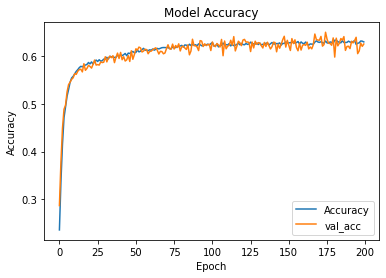

In [13]:
plt.plot( history.history['accuracy'], label="Accuracy")
plt.plot( history.history['val_accuracy'], label="val_acc")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

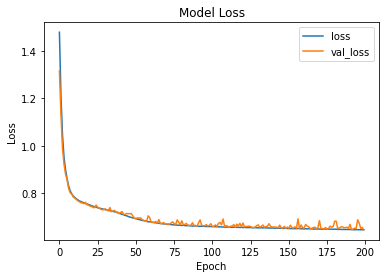

In [14]:
plt.plot( history.history['loss'], label="loss")
plt.plot( history.history['val_loss'], label="val_loss")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [15]:
# serialize weights to HDF5
bnn.save_weights("./model_weights_3PNN_with_sheath.h5")

In [10]:
preds = []
p = bnn( xTest )
en = bnn( xTest ).entropy()

for i in range( p.shape[0] ):
    preds.append( np.argmax(p[i,:]) )

In [11]:
font = { 'weight' : 'bold', 'size' : 24 }
plt.rc('font', **font)

In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(12, 12))

cm = confusion_matrix( yTest.astype(int), preds, normalize='true' )
disp = ConfusionMatrixDisplay( confusion_matrix=cm )
disp.plot(ax=ax, cmap='gist_yarg')

In [13]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

yTest = yTest.astype(int)

print( "Macro F1:", np.round( f1_score(yTest, preds, average='macro'), 4 ))
print( "Macro Precision:", np.round( precision_score(yTest, preds, average='macro'), 4 ))
print( "Macro Recall:", np.round( recall_score(yTest, preds, average='macro'), 4 ))
print( "Accuracy:", np.round( accuracy_score(yTest, preds), 4 ))

Macro F1: 0.6007
Macro Precision: 0.6002
Macro Recall: 0.6039
Accuracy: 0.6053


### If model already trained - Load the saved model for analysis

In [9]:
from keras import backend as K 

# Keras keeps models hanging around in memory. If we retrain a model, Keras will
# start from the previously concluded weight values. This resets everything.
K.clear_session()

bnn = create_probablistic_bnn_model( xTest.shape[0], xTest.shape[1] )
 
# load weights into new model
bnn.load_weights("./model_weights_3PNN_with_sheath.h5")

In [25]:
preds = []
p = bnn( xTest )
en = bnn( xTest ).entropy()

for i in range( p.shape[0] ):
    preds.append( np.argmax(p[i,:]) )